In [1166]:
import numpy as np
import time
import numpy.ma as ma
import matplotlib.pyplot as plt
import random
from itertools import product
import itertools
from collections import Counterm
from functools import reduce
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
colours = 8
places = 5
init_set = list(product(list(range(colours)),repeat = places))

In [1072]:
# helper functions

#returns the zero colours from a set list
def zero_colors(colour_list, set_list):
    res = []
    for col in colour_list:
        if col not in set_list:
            res.append(col)
    return res

def init_set(colour_list, places):
    return  np.array(list(product(colour_list, repeat = places)))

def set_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    #expected result
    xptd_rep = np.repeat([response], len(responses), axis=0)
    # test equality, sum on axis, if == 2 exactcly the same then gets the arguments
    equality = (responses == xptd_rep)
    s = np.sum(equality, axis=1) 
    args = (s == 2)
    return set_list[args]

def response(code, guess):
    black = white = 0
    code_t = list(code)
    guess_t = list(guess)
    for i in range(len(code)):
        if code_t[i] == guess_t[i]:
            black += 1
            code_t[i] = -1
            guess_t[i] = -1
    for i in range(len(code)):
        if guess_t[i] != -1:
            if guess_t[i] in code_t:
                code_t[code_t.index(guess_t[i])] = -1
                white += 1
    return (black, white)

    
def entropy(guess, code_set):
    results = resp_list(guess, code_set)
    distrib = np.array(list(Counter(results).values()))
    disp= distrib/sum(distrib)
    return -sum(np.log(disp)*disp)

# returns a try set with duplicate on free colors removed
def free_set(free_colors, set_list):
    if len(free_colors) <= 1:
        return set_list
    else:
        res_list = []
        for g in set_list: 
            g_res = []
            hash_res = {}
            nb_fc = 0
            for c in g:               
                if c in free_colors:
                    if c not in hash_res.keys():
                        nb_fc += 1
                        hash_res[c] = - nb_fc
                    g_res.append(hash_res[c])
                    
                else:
                    g_res.append(c)
            res_list.append(str(g_res).strip('[]'))
    #print("reslist:", res_list[:20])
    # keep unique values
    res_set = set(res_list)
    # str to list 
    res_arr = np.array([[int(e) for e in s.split(',')] for s in res_set])
    #print("res_arr:", res_arr[:20])
    for i, col in enumerate(free_colors):
       # print("set ", i, " with ", col)
        res_arr[res_arr == -(i+1)] = col
    return res_arr
                

In [1073]:
def first_true(arr, axis, invalid_val=-1):
    mask = arr==True
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def resp_list(guess, code_set):
    sets = code_set# np.array
    codes = np.repeat([guess], len(code_set), axis = 0)
    eq = np.equal(codes,sets)
    eq2 = np.copy(eq)
    blacks = eq.sum(axis=1) 

    codes_ma = ma.array(codes, mask = eq)
    codes_wh = codes_ma.T
    sets_ma = ma.array(sets, mask = eq2)
    whites = np.zeros(len(codes.T[0]), int)
   # print(sets_ma)
   # print(codes_ma)
    for i in range(len(codes_wh.T[0])):
        #print("Test %d columns %s" %(i,sets[:,i]))
        #print("sets", sets)
        columns = ma.repeat([sets_ma[:,i]], sets.shape[1], axis = 0)
        res = np.equal(columns, codes_wh)
        su = res.sum(axis = 0)
        #print("res   \n", res.T)
        bo = su > 0
        whites = whites + np.array(bo).astype(int)
       # print("whites", whites)
        ft = first_true(res,0)
        #print("ft", ft)
        #print("codes\n", codes)
        arg_ok = np.argwhere(np.array(ft) != -1)[:,0]
        ft_idx = tuple([np.array(ft)[arg_ok], arg_ok]) 
        codes_wh[ft_idx] = ma.masked
        #for j in range(len(res.T)):
        #    if ft[j] != -1:
        #        codes_wh[ft[j],j] = ma.masked
        #print("codes\n", codes)
    return list(zip(blacks, whites))

def resp_list_long(guess, set_list):
    return [response(s, guess) for s in set_list]

In [1158]:
class Game:
    def __init__(self, places=5, colors=8, code = ""):
        self.places = places
        self.colors = colors
        self.guess_list = list()
        self.resp_list = list()
        self.set_list = list()
        self.free_colors = list(range(colors))
        init_set = np.array(list(product(list(range(colors)), repeat = places)))
        self.set_list.append(init_set)
        self.cur_move = 0
        if code == "":
            self.code = [random.randint(0,colors-1) for _ in range(places)]
        else: 
            self.code = code
        #print("Code : ", self.code)
        self.play_function = lambda x: [random.randint(0,colors-1) for _ in range(places)]
    
    def set_play_function(self, pf):
        self.play_function = pf
    
    def get_free_colors(self, move):
        merge_l = list(itertools.chain.from_iterable(g.guess_list[:(g.cur_move)])) 
        self.free_colors = [col for col in list(range(self.colors)) if col not in merge_l]
        return self.free_colors
    
    def back(self):
        self.guess_list.pop()
        self.resp_list.pop()
        self.set_list.pop()
        self.cur_move -= 1   
    
    def print_tries(self):
        for i in range(self.cur_move):
            print("Played ", self.guess_list[i], "with response ", self.resp_list[i], len(self.set_list[i]), " left")
       
    def play(self, guess): 
        resp = response(self.code, guess)
        self.guess_list.append(guess)
        self.resp_list.append(resp)
        self.set_list.append(set_aft_resp(guess, resp, self.set_list[self.cur_move]))
        self.cur_move += 1
        return(resp)
    
    def automatic_play(self, verbose = True):
        
        while True or self.cur_move < 15:
            gu = self.play_function(self)
            resp = response(self.code, gu)
            self.play(gu)
            if verbose:
                print("Try %d: played %s, response %s, %d possiblities left" %(self.cur_move, gu, resp, 
                                                         len(self.set_list[self.cur_move]) )) 
            if resp == (self.places,0):
                return self.cur_move

In [1190]:
def play_bg_entropy(set_list, set_tries):
    res = {}
    for i in range(len(set_tries)):
        res[str(set_tries[i])] = round(entropy(set_tries[i], set_list),6)
    return res

def return_bg(set_list, set_tries):
    res = np.zeros(len(set_tries))
    for i in range(len(set_tries)):
        res[i] = round(entropy(set_tries[i], set_list),6)
    argmax = np.argwhere(res == res.max())[:,0]
    return(set_tries[argmax])
    
def play_rnd(g):
    r = random.randint(0, len(g.set_list[g.cur_move])-1)
    return g.set_list[g.cur_move][r]
    
def play_bg_rnd(g, try_list):
    poss = return_bg(g.set_list[g.cur_move], try_list)
    r = random.randint(0,len(poss)-1)
    return poss[r]

def play_bg(g):
    if len(g.set_list[g.cur_move]) > 2:
        try_list = reduce_set(g)
        return play_bg_rnd(g, try_list)
    else:
        return play_rnd(g)

In [1197]:
def reduce_set(g, move = -1):
    if move == -1:
        move = g.cur_move
    # first remove zero colours
    zc = zero_colors(list(range(g.colors)), g.set_list[g.cur_move])
    col_wo_zc = [col for col in list(range(g.colors)) if col not in zc]
    print("wo zero colours: ", col_wo_zc)
    wo_zc = init_set(col_wo_zc, g.places)
    #print("init set len", len(wo_zc))
    # then remove duplicate with free colours
    fc = g.get_free_colors(g.cur_move)
    print("free colours", fc)
    rdc_set = free_set(fc, wo_zc)
    print("try set length:", len(rdc_set))
    return rdc_set

In [1148]:
# test if optimization is relevant: It is x10 in time
%timeit resp_list_long(to_l("01230"), init_set_ar)
%timeit resp_list(to_l("01230"), init_set_ar)

459 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
43.3 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1233]:
# stat on game
def play_rnd_first(g):
    if g.cur_move == 0:
        return to_l("01233")
    else:
        return play_rnd(g)

# stat on game
def play_bg_rnd_first(g):
    if g.cur_move == 0:
        return to_l("01233")
    else:      
        return play_bg(g)
current = 0
nb_tests = 100
nb_tries = np.zeros(20, int)
lefts = np.zeros(20, int)
codes = []

In [1258]:
current

201

In [1260]:
start = time.time()
current_start = 201
nb_tests = 400
for i in range(current_start, nb_tests):
    g = Game(code = codes_rnd[i])
    print(i, "th with code", codes_rnd[i])
    g.set_play_function(play_bg_rnd_first)
    g.automatic_play(verbose = True)
    #store data
    #codes.append(g.code)
    nb_tries[g.cur_move] += 1
    cur_lefts = [len(s) for s in g.set_list]
    lefts[:len(cur_lefts)] += cur_lefts
    current += 1
    print("time spent", round((time.time() - start)/(i+1-current_start), 2), " s")

print("time spent", round(time.time() - start, 2), " s")

201 th with code [7, 1, 0, 7, 1]
Try 1: played [0, 1, 2, 3, 3], response (1, 1), 5432 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 5 2 3 6], response (0, 0), 76 possiblities left
wo zero colours:  [0, 1, 7]
free colours [7]
try set length: 243
Try 3: played [7 1 7 0 7], response (2, 2), 8 possiblities left
wo zero colours:  [0, 1, 7]
free colours []
try set length: 243
Try 4: played [7 1 1 7 7], response (3, 1), 2 possiblities left
Try 5: played [1 1 0 7 7], response (3, 2), 1 possiblities left
Try 6: played [7 1 0 7 1], response (5, 0), 1 possiblities left
time spent 28.11  s
202 th with code [3, 0, 0, 1, 6]
Try 1: played [0, 1, 2, 3, 3], response (0, 3), 3095 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 2 0 1 0], response (2, 1), 261 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [5, 6, 7]
try set le

Try 3: played [2 7 5 7 4], response (1, 1), 83 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [5 6 4 0 4], response (0, 4), 4 possiblities left
wo zero colours:  [0, 1, 4, 5, 6]
free colours []
try set length: 3125
Try 5: played [1 0 0 4 4], response (1, 2), 1 possiblities left
Try 6: played [6 4 5 4 1], response (5, 0), 1 possiblities left
time spent 119.57  s
213 th with code [3, 7, 4, 4, 1]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 5 4], response (0, 3), 672 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [1 5 6 7 0], response (0, 2), 73 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [5 2 4 0 2], response (1, 0), 7 possiblities left
wo zero colours

try set length: 4735
Try 2: played [1 2 4 5 4], response (1, 2), 837 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [4 0 6 2 4], response (1, 2), 102 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 4: played [2 2 1 6 4], response (0, 4), 8 possiblities left
wo zero colours:  [1, 2, 4, 6, 7]
free colours [7]
try set length: 3125
Try 5: played [7 4 4 2 1], response (2, 2), 1 possiblities left
Try 6: played [1 4 7 2 6], response (5, 0), 1 possiblities left
time spent 108.81  s
225 th with code [4, 5, 1, 3, 5]
Try 1: played [0, 1, 2, 3, 3], response (1, 1), 5432 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 1 5 6 3], response (1, 3), 245 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [1 5 1 7 3], response (2, 1), 20 possib

Try 5: played [7 6 6 0 1], response (0, 3), 1 possiblities left
Try 6: played [1 3 0 6 0], response (5, 0), 1 possiblities left
time spent 112.73  s
236 th with code [4, 3, 6, 4, 3]
Try 1: played [0, 1, 2, 3, 3], response (1, 1), 5432 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 5 2 6 3], response (2, 1), 369 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [4 6 2 1 7], response (1, 1), 60 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [2 5 6 0 6], response (1, 0), 8 possiblities left
wo zero colours:  [1, 3, 4, 5, 6]
free colours []
try set length: 3125
Try 5: played [4 1 1 5 4], response (1, 1), 1 possiblities left
Try 6: played [4 3 6 4 3], response (5, 0), 1 possiblities left
time spent 113.86  s
237 th with code [0, 2, 7, 7, 5]
Try 1: played [0, 1, 2, 3, 3], response (1, 1)

try set length: 4735
Try 2: played [0 4 5 6 3], response (1, 1), 801 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [0 0 7 1 6], response (0, 2), 131 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [7 5 1 7 3], response (1, 3), 3 possiblities left
wo zero colours:  [1, 3, 5, 7]
free colours []
try set length: 1024
Try 5: played [5 3 7 7 1], response (0, 4), 1 possiblities left
Try 6: played [1 5 5 3 7], response (5, 0), 1 possiblities left
time spent 119.27  s
248 th with code [6, 0, 2, 4, 3]
Try 1: played [0, 1, 2, 3, 3], response (2, 1), 1497 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [3 1 4 5 3], response (1, 1), 291 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [0 6 3 7 3], response (1, 2), 30 possiblitie

Try 3: played [2 3 3 3 6], response (0, 3), 8 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6]
free colours [7]
try set length: 16807
Try 4: played [1 4 1 6 1], response (1, 0), 1 possiblities left
Try 5: played [3 0 5 6 3], response (5, 0), 1 possiblities left
time spent 120.13  s
259 th with code [4, 3, 7, 5, 1]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [2 0 4 5 4], response (1, 1), 1164 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [1 6 0 5 0], response (1, 1), 164 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 4: played [7 2 0 6 2], response (0, 1), 17 possiblities left
wo zero colours:  [0, 1, 3, 4, 5, 6, 7]
free colours []
try set length: 16807
Try 5: played [1 3 4 7 7], response (1, 3), 2 possiblities left
Try 6: 

try set length: 4735
Try 2: played [2 0 4 4 5], response (2, 2), 135 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [2 6 0 4 0], response (4, 0), 4 possiblities left
wo zero colours:  [0, 2, 4, 5, 6]
free colours [7]
try set length: 3125
Try 4: played [0 6 5 4 5], response (1, 1), 1 possiblities left
Try 5: played [2 4 0 4 0], response (5, 0), 1 possiblities left
time spent 119.96  s
271 th with code [5, 7, 4, 0, 2]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 4 5], response (0, 3), 672 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [1 5 6 0 7], response (1, 2), 111 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [1 6 5 2 4], response (0, 3), 13 poss

try set length: 4735
Try 2: played [4 5 6 5 1], response (0, 3), 590 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [1 6 7 4 7], response (1, 2), 76 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [5 4 7 6 2], response (1, 2), 9 possiblities left
wo zero colours:  [1, 4, 5, 6, 7]
free colours []
try set length: 3125
Try 5: played [4 7 5 7 4], response (2, 0), 1 possiblities left
Try 6: played [1 7 5 6 6], response (5, 0), 1 possiblities left
time spent 119.84  s
283 th with code [4, 0, 5, 4, 7]
Try 1: played [0, 1, 2, 3, 3], response (0, 1), 5196 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 5 6 6 2], response (1, 1), 829 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [4 7 5 0 5], response (2, 2), 31 possiblities

Try 4: played [7 5 5 7 2], response (1, 1), 5 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 5: played [4 7 7 1 5], response (1, 1), 1 possiblities left
Try 6: played [6 7 6 7 0], response (5, 0), 1 possiblities left
time spent 118.59  s
294 th with code [5, 2, 1, 7, 7]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 5 4], response (1, 1), 1164 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [1 2 6 5 1], response (1, 2), 99 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 4: played [5 0 6 7 2], response (2, 1), 4 possiblities left
wo zero colours:  [1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 16807
Try 5: played [1 7 7 4 2], response (0, 4), 1 possiblities left
Try 6: 

Try 5: played [6 7 7 7 6], response (1, 0), 1 possiblities left
Try 6: played [6 0 3 4 0], response (5, 0), 1 possiblities left
time spent 119.42  s
305 th with code [4, 0, 0, 4, 1]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 4 5], response (3, 1), 43 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [4 6 1 0 0], response (1, 3), 6 possiblities left
wo zero colours:  [0, 1, 4, 5, 6]
free colours [7]
try set length: 3125
Try 4: played [4 1 0 1 5], response (2, 1), 1 possiblities left
Try 5: played [4 0 0 4 1], response (5, 0), 1 possiblities left
time spent 118.93  s
306 th with code [3, 5, 4, 4, 0]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 5 4], r

Try 4: played [0 2 0 1 5], response (2, 2), 3 possiblities left
wo zero colours:  [0, 1, 2, 4, 5]
free colours []
try set length: 3125
Try 5: played [0 5 5 1 2], response (4, 0), 1 possiblities left
Try 6: played [0 5 2 1 2], response (5, 0), 1 possiblities left
time spent 118.06  s
317 th with code [6, 5, 2, 2, 6]
Try 1: played [0, 1, 2, 3, 3], response (1, 0), 2387 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 4 5 3 6], response (1, 1), 384 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [0 6 5 6 7], response (0, 3), 31 possiblities left
wo zero colours:  [1, 2, 4, 5, 6, 7]
free colours []
try set length: 7776
Try 4: played [6 7 2 5 7], response (2, 1), 1 possiblities left
Try 5: played [6 5 2 2 6], response (5, 0), 1 possiblities left
time spent 117.81  s
318 th with code [4, 3, 7, 2, 5]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 

Try 3: played [5 6 7 4 4], response (1, 3), 15 possiblities left
wo zero colours:  [4, 5, 6, 7]
free colours []
try set length: 1024
Try 4: played [7 6 4 6 5], response (3, 0), 2 possiblities left
Try 5: played [5 4 4 6 5], response (2, 3), 1 possiblities left
Try 6: played [4 6 4 5 5], response (5, 0), 1 possiblities left
time spent 115.13  s
329 th with code [2, 7, 4, 1, 3]
Try 1: played [0, 1, 2, 3, 3], response (1, 2), 3510 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 3 5 6 3], response (1, 1), 558 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [2 2 1 5 3], response (2, 1), 56 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 4: played [2 7 4 1 3], response (5, 0), 1 possiblities left
time spent 115.4  s
330 th with code [6, 4, 6, 6, 3]
Try 1: played [0, 1, 2, 3, 3], response (1, 0), 

try set length: 4735
Try 2: played [4 2 0 4 5], response (1, 2), 837 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [6 4 1 4 0], response (1, 2), 102 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 4: played [2 0 0 4 6], response (2, 1), 5 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6]
free colours [7]
try set length: 16807
Try 5: played [0 4 6 5 0], response (1, 1), 1 possiblities left
Try 6: played [2 3 6 4 4], response (5, 0), 1 possiblities left
time spent 115.41  s
342 th with code [3, 4, 0, 1, 7]
Try 1: played [0, 1, 2, 3, 3], response (0, 3), 3095 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [2 4 1 1 0], response (2, 1), 261 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [5, 6, 7]
try set length: 10391
Try 3: played [2 0 5 1 6], response (1, 

try set length: 4735
Try 2: played [4 1 5 6 3], response (2, 0), 293 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [5 1 7 1 2], response (1, 1), 48 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [6 1 6 7 0], response (2, 1), 5 possiblities left
wo zero colours:  [0, 1, 2, 4, 6, 7]
free colours []
try set length: 7776
Try 5: played [4 0 0 4 6], response (0, 2), 1 possiblities left
Try 6: played [1 1 1 6 0], response (5, 0), 1 possiblities left
time spent 113.29  s
354 th with code [2, 7, 0, 3, 7]
Try 1: played [0, 1, 2, 3, 3], response (1, 2), 3510 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 5 3 6 3], response (0, 1), 491 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [0 2 1 4 1], response (0, 2), 65 possiblit

try set length: 4735
Try 2: played [4 5 6 6 2], response (0, 2), 896 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [5 6 0 7 7], response (3, 0), 33 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 32768
Try 4: played [5 4 5 0 7], response (1, 0), 3 possiblities left
wo zero colours:  [1, 2, 3, 6, 7]
free colours []
try set length: 3125
Try 5: played [6 3 3 6 7], response (2, 1), 1 possiblities left
Try 6: played [6 6 1 7 7], response (5, 0), 1 possiblities left
time spent 112.84  s
366 th with code [5, 5, 6, 7, 4]
Try 1: played [0, 1, 2, 3, 3], response (0, 0), 1024 possiblities left
wo zero colours:  [4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 51
Try 2: played [4 5 6 5 4], response (3, 1), 32 possiblities left
wo zero colours:  [4, 5, 6, 7]
free colours [7]
try set length: 1024
Try 3: played [7 4 4 5 4], response (1, 2), 4 possiblities left
wo zero colours:  [4, 5

Try 5: played [5 5 6 4 7], response (0, 3), 1 possiblities left
Try 6: played [7 4 1 0 6], response (5, 0), 1 possiblities left
time spent 1386.81  s
377 th with code [7, 0, 7, 0, 2]
Try 1: played [0, 1, 2, 3, 3], response (0, 2), 7051 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 0 1 4 5], response (1, 0), 513 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [6, 7]
try set length: 20272
Try 3: played [2 2 1 6 7], response (0, 2), 56 possiblities left
wo zero colours:  [0, 2, 3, 4, 5, 6, 7]
free colours []
try set length: 16807
Try 4: played [3 5 7 7 2], response (2, 1), 5 possiblities left
wo zero colours:  [0, 2, 3, 5, 6, 7]
free colours []
try set length: 7776
Try 5: played [5 5 6 0 7], response (1, 1), 1 possiblities left
Try 6: played [7 0 7 0 2], response (5, 0), 1 possiblities left
time spent 1379.6  s
378 th with code [4, 3, 0, 1, 1]
Try 1: played [0, 1, 2, 3, 3], response (0

Try 5: played [1 5 4 6 5], response (1, 4), 1 possiblities left
Try 6: played [5 6 4 5 1], response (5, 0), 1 possiblities left
time spent 1312.05  s
388 th with code [4, 6, 1, 1, 6]
Try 1: played [0, 1, 2, 3, 3], response (0, 1), 5196 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [4, 5, 6, 7]
try set length: 4735
Try 2: played [4 5 6 6 2], response (1, 2), 779 possiblities left
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
free colours [7]
try set length: 32768
Try 3: played [6 7 6 1 4], response (1, 3), 46 possiblities left
wo zero colours:  [0, 1, 3, 4, 5, 6, 7]
free colours []
try set length: 16807
Try 4: played [5 4 4 6 1], response (0, 3), 5 possiblities left
wo zero colours:  [1, 4, 5, 6, 7]
free colours []
try set length: 3125
Try 5: played [1 7 6 5 7], response (0, 2), 1 possiblities left
Try 6: played [4 6 1 1 6], response (5, 0), 1 possiblities left
time spent 1305.76  s
389 th with code [5, 6, 4, 1, 6]
Try 1: played [0, 1, 2, 3, 3], response (0, 1),

Try 4: played [4 4 6 4 7], response (1, 2), 1 possiblities left
Try 5: played [7 6 4 7 7], response (5, 0), 1 possiblities left
time spent 1237.86  s
time spent 246333.75  s


In [1261]:
nb_tries_bg = nb_tries
lefts_bg = lefts
codes_bg = codes

In [1266]:
f = open("codes_bg.txt", "w")
f.write(str(codes_bg))
f.close()

c:\users\lm217404\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
c:\users\lm217404\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


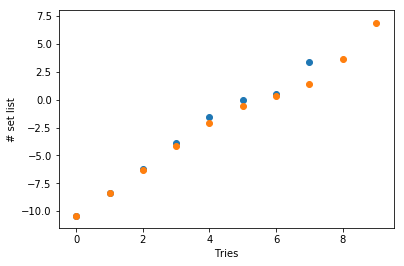

[(32768.0, 32768.0),
 (4387.2126168224295, 4338.768),
 (493.04672897196264, 547.58),
 (49.41822429906542, 65.141),
 (4.600467289719626, 7.947),
 (1.0373831775700935, 1.759),
 (0.5957943925233645, 0.728),
 (0.035046728971962614, 0.239),
 (0.0, 0.027),
 (0.0, 0.001),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)]

In [1267]:
plt.scatter(list(range(20)), [-np.log(float(l)/sum(nb_tries_bg)) for l in lefts_bg])
plt.scatter(list(range(20)), [-np.log(float(l)/sum(nb_tries_rnd)) for l in lefts_rnd])
plt.xlabel("Tries")
plt.ylabel("# set list")
plt.savefig("left_rnd_first.png")
plt.show()
list(zip(lefts_bg/sum(nb_tries_bg), lefts_rnd/sum(nb_tries_rnd)))

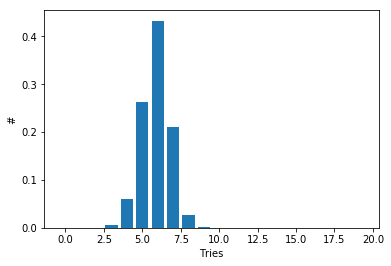

Mean: 5.862


In [1268]:
plt.bar(list(range(20)), nb_tries_rnd/sum(nb_tries_rnd))
plt.xlabel("Tries")
plt.ylabel("#")
plt.savefig("random_first.png")
plt.show()
print("Mean:", sum([i*nb_tries_rnd[i] for i in range(20) ])/sum(nb_tries_rnd))

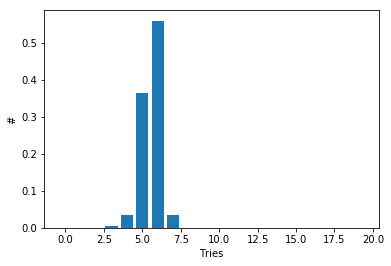

Mean: 5.586448598130841


In [1269]:
plt.bar(list(range(20)), nb_tries_bg/sum(nb_tries_bg))
plt.xlabel("Tries")
plt.ylabel("#")
plt.savefig("bg_first.png")
plt.show()
print("Mean:", sum([i*nb_tries_bg[i] for i in range(20) ])/sum(nb_tries_bg))

In [1125]:
g = Game()
g.set_play_function(play_rnd)
print("Response" + str(g.play(to_l("01230"))))
try_set = reduce_set(g)
print("reduced to ", len(try_set))
play_rnd(g, try_set)

Code :  [6, 6, 5, 2, 2]
Response(0, 1)
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
init set len 32768
free colours [4, 5, 6, 7]
reduced to  4735


array([3, 4, 5, 6, 6])

In [1126]:
g.play(to_l("34566"))

(1, 2)

In [1127]:
print(g.guess_list)
print(g.resp_list)
print(len(g.set_list[-1]))

[[0, 1, 2, 3, 0], [3, 4, 5, 6, 6]]
[(0, 1), (1, 2)]
779


In [1131]:
try_set = reduce_set(g)
print("reduced to ", len(try_set))
print(try_set)
play_rnd(g)

wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
init set len 32768
free colours [7]
reduced to  32768
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 2]
 ...
 [7 7 7 7 5]
 [7 7 7 7 6]
 [7 7 7 7 7]]


array([6, 3, 5, 7, 5])

In [1132]:
g.play(to_l("63575"))

(2, 0)

In [1133]:
print(g.guess_list)
print(g.resp_list)
print(len(g.set_list[-1]))

[[0, 1, 2, 3, 0], [3, 4, 5, 6, 6], [6, 3, 5, 7, 5]]
[(0, 1), (1, 2), (2, 0)]
26


In [930]:
g.set_list[-1]

array([[4, 1, 4, 5, 5],
       [4, 5, 5, 1, 1],
       [5, 5, 4, 1, 1]])

In [929]:
resp_list(to_l("43221"), g.set_list[-1])

[(1, 1), (2, 0), (1, 1)]

In [927]:
np.array(g.code) in g.set_list[-1]

True

In [926]:
g.set_list[-1].index([5,5,4,1,1])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [12]:
code = [int(i) for i in "00111"]
nb_tests = 20000
sets = init_set
sets.append([int(i) for i in "11100"])
sets = np.array(sets)
codes = np.repeat([code], len(init_set), axis = 0)

In [68]:
if True: #testing database
    code = [int(i) for i in "00111"]
    nb_tests = 6
    sets = [[random.randint(0, colours-1) for _ in range(places)] for _ in range(nb_tests-1)]
    sets.append([int(i) for i in "11100"])
    sets = np.array(sets)
    codes = np.repeat([code], nb_tests, axis = 0)

In [69]:
codes

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [70]:
sets

array([[2, 4, 5, 4, 4],
       [2, 3, 3, 4, 2],
       [5, 5, 7, 4, 5],
       [2, 6, 7, 1, 3],
       [2, 3, 4, 6, 4],
       [1, 1, 1, 0, 0]])

In [71]:
# nb blacks directly
eq = np.equal(codes,sets)
blacks = eq.sum(axis=1) 
print(blacks)

[0 0 0 1 0 1]


In [72]:
codes_ma = ma.array(codes, mask =eq)
codes_ma

masked_array(
  data=[[0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, --, 1],
        [0, 0, 1, 1, 1],
        [0, 0, --, 1, 1]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False],
        [False, False, False, False, False],
        [False, False,  True, False, False]],
  fill_value=999999)

In [73]:
sets_ma = ma.array(sets, mask = eq)
sets_ma

masked_array(
  data=[[2, 4, 5, 4, 4],
        [2, 3, 3, 4, 2],
        [5, 5, 7, 4, 5],
        [2, 6, 7, --, 3],
        [2, 3, 4, 6, 4],
        [1, 1, --, 0, 0]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False],
        [False, False, False, False, False],
        [False, False,  True, False, False]],
  fill_value=999999)

In [74]:
first = ma.repeat([sets_ma[:,0]], sets.shape[1], axis = 0)
first

masked_array(
  data=[[2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1]],
  mask=False,
  fill_value=999999)

In [75]:
codes_wh = codes_ma.T
codes_wh

masked_array(
  data=[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, --],
        [1, 1, 1, --, 1, 1],
        [1, 1, 1, 1, 1, 1]],
  mask=[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False,  True],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False]],
  fill_value=999999)

In [76]:
w1 = np.equal(first, codes_wh)
s1 = w1.sum(axis = 0)

In [77]:
whites = s1 > 0
w = np.array(whites.astype(int))
w

array([0, 0, 0, 0, 0, 1])

In [79]:
print(code)
print(sets_ma)

[0, 0, 1, 1, 1]
[[2 4 5 4 4]
 [2 3 3 4 2]
 [5 5 7 4 5]
 [2 6 7 -- 3]
 [2 3 4 6 4]
 [1 1 -- 0 0]]


In [271]:

blacks = eq.sum(axis=1) 
print("blacks", blacks)


eq = np.equal(codes,sets)
eq2 = np.equal(codes,sets)
codes_ma = ma.array(codes, mask =eq)
codes_wh = codes_ma.T
sets_ma = ma.array(sets, mask = eq2)

def calc_whites(codes, sets):
    whites = np.zeros(len(codes[0]), int)
    for i in range(len(codes.T[0])):
        #print("Test %d columns %s" %(i,sets[:,i]))
        #print("sets", sets)
        columns = ma.repeat([sets[:,i]], sets.shape[1], axis = 0)
        res = np.equal(columns, codes_wh)
        su = res.sum(axis = 0)
        #print("res   \n", res.T)
        bo = su > 0
        whites = whites + np.array(bo).astype(int)
        #print("whites", whites)
        ft = first_true(res,0)
        arg_ok = np.argwhere(np.array(ft) != -1)[:,0]
        ft_idx = [tuple(np.array(ft)[arg_ok]), tuple(arg_ok) ]
        codes[ft_idx] = ma.masked
        print("ft", ft)
        print("codes\n", codes)
        #for j in range(len(res.T)):
        #    if ft[j] != -1:
        #        codes[ft[j],j] = ma.masked
        #codes[ft,(i)*len(ft)] = ma.masked
        print("codes\n", codes)
        
        #print("codes\n", codes)
    return whites

whites = calc_whites(codes_wh, sets_ma)
print(sum(whites))
results = list(zip(blacks, whites))
distrib = np.array(list(Counter(results).values()))

print(Counter(results))
Counter(results).values() # counts the elements' frequency

blacks [0 0 0 1 0 5]
ft [-1 -1 -1 -1 -1  3]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 1]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 1]]
ft [-1 -1 -1 -1 -1  4]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1 -1]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1  0]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1  1]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 --]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 --]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1

c:\users\lm217404\appdata\local\continuum\anaconda3\lib\site-packages\numpy\ma\core.py:3312: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  _mask[indx] = True


dict_values([4, 1, 1])

In [87]:
disp= distrib/sum(distrib)
sum(np.log(disp)*disp)

-1.242453324894

In [273]:
init_set_ar = np.array(init_set)
#%timeit entropy(code, init_set_ar)

In [192]:
%lprun -f entropy entropy(code, init_set_ar)

In [193]:
entropy(code, init_set_ar)

1.9891050050191246

In [539]:
from itertools import product
col = list(range(colours))

In [ ]:
res = {}
for i in range(len(init_set)):
    res[init_set[i]] = entropy(init_set[i], init_set_ar)
    if i % 100 == 0:
        print(i)

In [550]:
type(list(product(col,repeat = places))[0])

tuple

In [553]:
init_set = list(product(list(range(colours)),repeat = places))

In [554]:
len(init_set)

32768

In [199]:
f = open("res_first.txt", "w")
f.write(str(res))
f.close()

In [208]:
res_trunc = {}

for k,v in res.items():
    res_trunc[k] = round(res[k], 6)

In [214]:
hist_res = {}
for k,v in res_trunc.items():
    if v not in hist_res.keys():
        hist_res[v] = 1
    else:
        hist_res[v] += 1
print(hist_res)
print(len(hist_res))
print(sum(hist_res.values()))

{1.017037: 8, 2.024142: 280, 1.989105: 560, 2.25075: 3360, 2.263648: 5040, 2.312146: 16800, 2.239942: 6720}
7
32768


In [216]:
def to_l(string):
    return [int(s) for s in string]

In [217]:
entropy(to_l("00000"), init_set_ar)

1.0170366574100151

In [218]:
entropy(to_l("11220"), init_set_ar)

2.2636478202301484

In [952]:
first_try = dict.fromkeys(["00000", "01111", "00111", "01222", "00112", "01233", "01234"])
for k in first_try:
    first_try[k] = round(entropy(to_l(k), init_set_ar ), 6)
print(first_try)

{'00000': 1.017037, '01111': 2.024142, '00111': 1.989105, '01222': 2.25075, '00112': 2.263648, '01233': 2.312146, '01234': 2.239942}


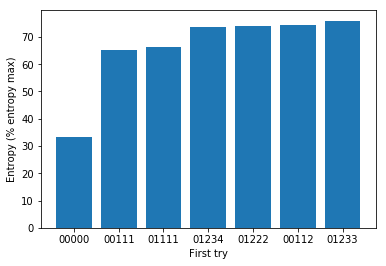

In [953]:
entropy_max= np.log(len(all_responses))
ft_std = {k: v for k, v in sorted(first_try.items(), key=lambda item: item[1])}
plt.bar(ft_std.keys(), np.array(list((ft_std.values())))*100 / entropy_max)
plt.xlabel("First try")
plt.ylabel("Entropy (% entropy max)")
plt.savefig("first_try_hist.png")
plt.show()

In [235]:
card =len(init_set_ar)

In [238]:
np.log(1/card)

-10.39720770839918

In [243]:
all_responses = [(i,j) for i in range(places+1) for j in range(places+1) if i+j<6]

In [252]:
optimum = card / len(all_responses)
entropy_max= np.log(len(all_responses))

In [266]:
np.array(list((ft_std.values())))*100 / entropy_max

array([33.40546903, 65.33389195, 66.48471284, 73.57285242, 73.92785062,
       74.35149671, 75.9444559 ])

In [376]:
def set_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    #expected result
    xptd_rep = np.repeat([response], len(responses), axis=0)
    # test equality, sum on axis, if == 2 exactcly the same then gets the arguments
    equality = (responses == xptd_rep)
    s = np.sum(equality, axis=1) 
    args = (s == 2)
    return set_list[args]
    
%timeit set_aft_resp(to_l("01234"), (0,5), init_set_ar)
%lprun -f set_aft_resp set_aft_resp(to_l("01234"), (0,5), init_set_ar)

70.2 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [375]:
# actually not slow on this simple example
# sometimes looping is not so bad
def slow_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    res = []
    for i,rep in enumerate(responses):
        if rep == response:
            res.append(set_list[i])
    return res

%timeit slow_aft_resp(to_l("01234"), (0,5), init_set_ar)     
%lprun -f slow_aft_resp slow_aft_resp(to_l("01234"), (0,5), init_set_ar) 

64.6 ms ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [342]:
init_set_ar[np.argwhere(rep == np.array([0,5]))[:,0]]
init_set_ar[np.argwhere(rep == [0,5])[:,0]]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 2],
       ...,
       [7, 7, 7, 7, 5],
       [7, 7, 7, 7, 6],
       [7, 7, 7, 7, 7]])

In [ ]:
#expected result
xptd_rep = np.repeat([[0,5]], rep.shape[0], axis=0)
# test equality, sum on axis, if == 2 exactcly the same then gets the arguments
init_set_ar[(np.sum(rep == xptd_rep, axis=1) == 2)]

In [1130]:
def play_bg_entropy(set_list, set_tries):
    res = {}
    for i in range(len(set_tries)):
        res[str(set_tries[i])] = round(entropy(set_tries[i], set_list),6)
    return res

def return_bg(set_list, set_tries):
    res = np.zeros(len(set_tries))
    for i in range(len(set_tries)):
        res[i] = round(entropy(set_tries[i], set_list),6)
    argmax = np.argwhere(res == res.max())[:,0]
    return(set_tries[argmax])
    

def play_rnd(g):
    r = random.randint(0, len(g.set_list[g.cur_move]))
    return g.set_list[g.cur_move][r]
    
def play_bg_rnd(g, try_list):
    poss = return_bg(g.set_list[g.cur_move], try_list)
    r = random.randint(0,len(poss)-1)
    return poss[r]

def play_bg(g):
    try_list = reduce_set(g)
    return play_bg_rnd(g, try_list)

In [709]:
r = set_aft_resp(to_l("01234"), (0,5), init_set_ar)
print(len(r))
print(g.cur_move)
print(g.set_list[-1])
play_random(g, r)
#%timeit res_test= play_bg_entropy_np(r, r)
#%timeit res_test= play_bg_entropy(r, r)

44
1
[[0 4 0 0 0]
 [0 4 0 0 4]
 [0 4 0 0 5]
 ...
 [7 7 7 1 3]
 [7 7 7 2 0]
 [7 7 7 2 1]]
[[1 4 0 2 3]
 [2 4 1 0 3]
 [3 4 1 2 0]
 [4 2 1 0 3]
 [4 3 1 2 0]]
3


array([3, 4, 1, 2, 0])

In [424]:
# There are 21 possible responses to the first try 
rr = np.vectorize(round)
res05 = rr(res05, 6)
res05.max()
r[res_test.argmax()]

array([1, 2, 3, 4, 0])

In [ ]:
init_set_ar[np.argwhere(res05 == res05.max())[:,0]]

In [423]:
Counter(resp_list([1, 2, 0, 0, 3], r))

Counter({(1, 3): 9,
         (2, 2): 2,
         (4, 1): 2,
         (2, 3): 8,
         (3, 2): 3,
         (0, 4): 11,
         (1, 4): 9})

In [435]:
np.array(list(Counter(resp_list([1, 2, 3, 4, 0],r)).values()))**2

array([ 25, 225,   1, 100, 169], dtype=int32)

In [440]:
# esperance from a distribution of responses
def esp(di):
    n = np.array(list(di.values()))
    return sum(n**2)/sum(n)

print(esp(Counter(resp_list([1, 2, 0, 0, 3], r))))
print(esp(Counter(resp_list([1, 2, 3, 4, 0],r))))

8.272727272727273
11.818181818181818


In [446]:
try_set = list(product(colour_list,repeat = places))

len(try_set)

3125

In [447]:
5**5

3125

In [734]:
def free_set(free_colors, set_list):
    if len(free_colors) <= 1:
        return set_list
    else:
        res_list = []
        for g in set_list: 
            g_res = []
            hash_res = {}
            nb_fc = 0
            for c in g:               
                if c in free_colors:
                    if c not in hash_res.keys():
                        nb_fc += 1
                        hash_res[c] = - nb_fc
                    g_res.append(hash_res[c])
                    
                else:
                    g_res.append(c)
            res_list.append(str(g_res).strip('[]'))
    # keep unique values
    res_set = set(res_list)
    # str to list 
    res_arr = np.array([[int(e) for e in s.split(',')] for s in string])
    for i, col in enumerate(free_colors):
        res_arr[res_arr == -i] = col
    return res_arr
                

In [737]:
fr = free_set([4,5,6,7], init_set)
#len(reduce(lambda l, x: l.append(x) or l if x not in l else l, fr, []))
print(len(fr))
print(len(init_set))

4735
32768


In [724]:
unique = []
for e in fr:
    if e not in unique:
        unique.append(e)

[int(e) for e in unique[0].strip('[]').split(',')]

[3, -1, -1, -2, 2]

In [712]:
len(unique)

4735

In [725]:
string = []
for e in fr:
    string.append(str(e).strip('[]'))

In [726]:
len(set(string))

4735

In [732]:
r = np.array([[int(e) for e in s.split(',')] for s in string])
r[r == -1] = 4

In [733]:
r

array([[ 3,  4,  4, -2,  2],
       [ 4,  0,  0,  4,  2],
       [ 4,  3,  0, -2,  0],
       ...,
       [ 4,  3,  3,  3,  1],
       [ 0,  3,  0,  4, -2],
       [ 1,  1,  4,  2,  4]])